In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\pivansla\AppData\Local\Temp\ipykernel_9004\2151744951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [9]:
def read_slopes(filename):
    df = pd.read_csv(
        filename,
        sep='\t',
        header=None,
        names=['time', 'date', 'barcode', 'temp', 'curr_low', 'curr_high', 't_wait', 't_sample', 'slope', 'status', 'flow', 'flow2']
    )
    df = df.filter(['barcode', 'flow', 'slope'])
    return df

In [10]:
df = read_slopes('Raw_Data_ALIMCH_62.xls')

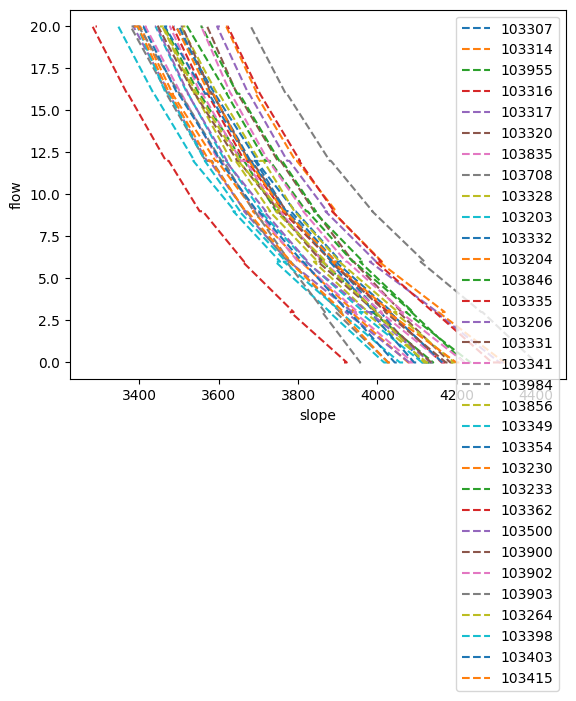

In [11]:
barcodes = [b for b in set(df['barcode'])]
for barcode in barcodes:
    df_sel = df[df.barcode == barcode]
    
    plt.plot(df_sel['slope'], df_sel['flow'], '--')
plt.xlabel('slope')
plt.ylabel('flow')
plt.legend(barcodes)

plt.show()

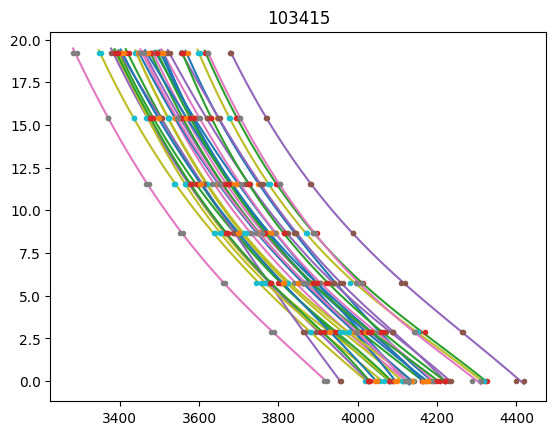

In [12]:
calib_params = dict()
for barcode in set(df['barcode']):
    df_sel = df[df.barcode == barcode]
    
    flows_corrected = [v*0.9621 for v in df_sel['flow']]

    params = np.polynomial.polynomial.polyfit(df_sel['slope'], flows_corrected, 4)
    calib_params[barcode] = params
    xx = np.linspace(min(df_sel['slope']), max(df_sel['slope']), 100)
    yy = [np.dot(params, [1, x, x**2, x**3, x**4]) for x in xx]
    plt.plot(xx, yy)
    
    plt.plot(df_sel['slope'], flows_corrected, '.')
    plt.title(barcode)
    
    # plt.show()

In [13]:
import csv
with open('new_calib_constants.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow([
        'ID', 'CellID',
        'low_x0', 'low_x1', 'low_x2', 'low_x3', 'low_x4',
        'low_ZeroFlowSlope',
        'low_minFlow','low_maxFlow',
        'high_x0', 'high_x1', 'high_x2', 'high_x3', 'high_x4',
        'high_ZeroFlowSlope',
        'high_minFlow', 'high_maxFlow',
        'DateTimeStamp',
        'CalibrationGas'
    ])
    
    for k, v in calib_params.items():
        spamwriter.writerow([
            0, k,
            v[0], v[1], v[2], v[3], v[4],
            int(df[(df.barcode == k) & (df.flow==0)].iloc[0].slope),
            0, 20,
            0, 0, 0, 0, 0,
            -1,
            -1, -1,
            '16/02/2024 12:00:00',
            '85Ar15CO2'
        ])